In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os 
import osmnx as ox

df_all = pd.read_csv("df_all.csv")

In [23]:
print(df_all.dtypes)
numeric_cols = [
    "channels_in", "channels_out", "channels_unknown", "channels_all", 
    "site_temperature", "site_rain_accumulation", "site_snow_accumulation"]

df_all[numeric_cols] = df_all[numeric_cols].apply(pd.to_numeric, errors='coerce')

operator_name              object
domain_name                object
domain_id                   int64
counter_site               object
counter_site_id             int64
counter_serial             object
longitude                 float64
latitude                  float64
timezone                   object
iso_timestamp              object
channels_in               float64
channels_out              float64
channels_unknown          float64
channels_all                int64
site_temperature          float64
site_rain_accumulation    float64
site_snow_accumulation    float64
day                        object
dtype: object


In [24]:
df_tue = df_all[df_all["domain_name"] == "Stadt Tübingen"]
df_tue = df_tue.groupby("counter_site")

tue_coords = {
    name: (
        df_tue.get_group(name)["latitude"].iloc[0],
        df_tue.get_group(name)["longitude"].iloc[0]
    )
    for name in df_tue.groups.keys()
}
tue_coords

{'Fuß- & Radtunnel Südportal - Derendinger Allee': (np.float64(48.518),
  np.float64(9.04806)),
 'Neckartalradweg Hirschau - parallel L371': (np.float64(48.50357),
  np.float64(9.02496)),
 'Radbrücke Mitte - Wöhrdstraße': (np.float64(48.5178), np.float64(9.06091)),
 'Radbrücke Ost': (np.float64(48.51824), np.float64(9.06905)),
 'Unterführung Steinlach/Karlstraße Südseite - Steinlachallee': (np.float64(48.515434),
  np.float64(9.058865))}

In [ ]:

center_point = (48.518, 9.048)  

G = ox.graph_from_point(center_point, dist=3000, network_type='bike')

In [26]:
snapped_nodes = {}
for name, (lat, lon) in tue_coords.items():
    node = ox.distance.nearest_nodes(G, X=lon, Y=lat)
    snapped_nodes[name] = node

In [27]:
import networkx as nx
u = snapped_nodes['Fuß- & Radtunnel Südportal - Derendinger Allee']
v = snapped_nodes['Radbrücke Ost']
w = snapped_nodes['Neckartalradweg Hirschau - parallel L371']

distance_m = nx.shortest_path_length(G, u, v, weight='length')
distance_n = nx.shortest_path_length(G, v, w, weight='length')
distance_p = nx.shortest_path_length(G, u, w, weight='length')
print(f"Fahrrad-Distanz: {distance_m:.1f} m")
print(f"Fahrrad-Distanz: {distance_n:.1f} m")
print(f"Fahrrad-Distanz: {distance_p:.1f} m")

Fahrrad-Distanz: 1906.1 m
Fahrrad-Distanz: 4373.7 m
Fahrrad-Distanz: 2521.1 m


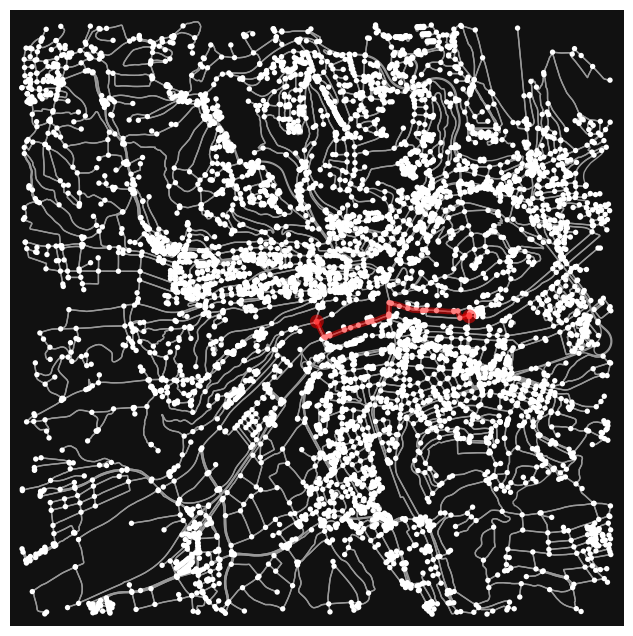

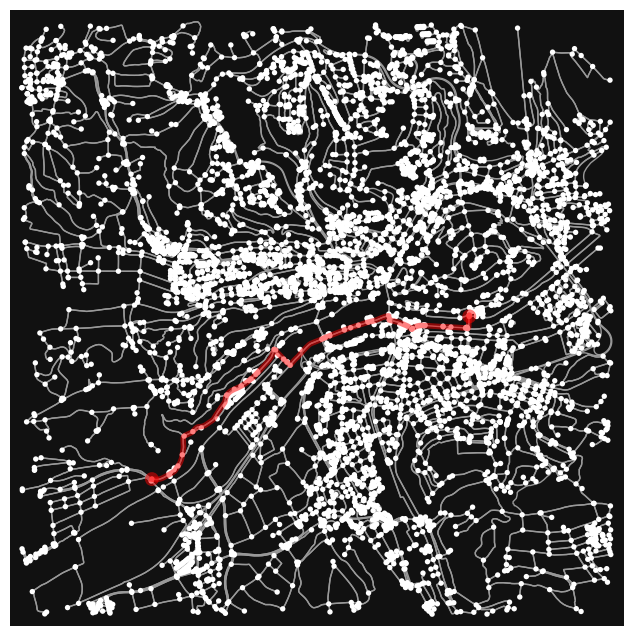

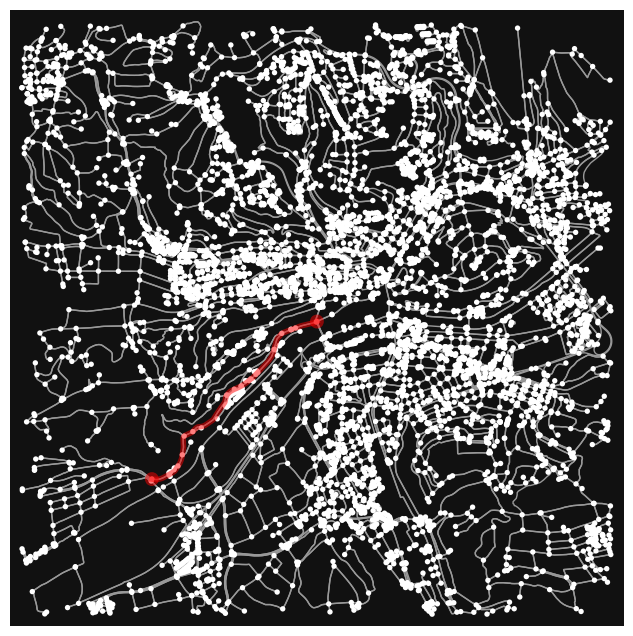

In [28]:
route = nx.shortest_path(G, u, v, weight='length')
routte1 = nx.shortest_path(G, v, w, weight='length')
route2 = nx.shortest_path(G, u, w, weight='length')
ox.plot_graph_route(G, route)
ox.plot_graph_route(G, routte1)
ox.plot_graph_route(G, route2)
plt.show()